In [1]:
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd
from time import sleep
from sklearn.model_selection import train_test_split
plt.rcParams['axes.grid'] = True

In [2]:
X = np.load("train.npz")["x"]
y = np.load("train.npz")["y"]
x_global = np.load("test.npz")["x"]
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=500, shuffle=True, stratify=y
)
fs = 16000
print(x_test.shape, y_test.shape, x_global.shape)

(563, 16000) (563,) (750, 16000)


<h2><center>Check simple solution and its score: </center></h2>

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
model = LogisticRegression(max_iter=1e6)

model.fit(x_train, y_train)
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

1.0
0.35879218472468916


In [5]:
baseline = np.ones(y_test.shape) * 2

In [6]:
print(accuracy_score(y_test, baseline))

0.3339253996447602


<h2><center>Check better solution and its score: </center></h2>

(129,) (1687, 129)


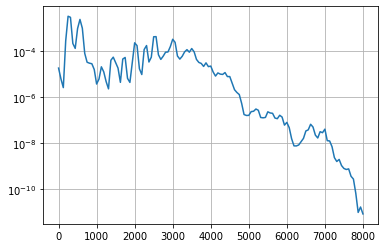

In [7]:
# plot a spectrum of some sample
freq, x_spec_train = sg.welch(x_train, fs, axis=1, )
print(freq.shape, x_spec_train.shape)
plt.semilogy(freq, x_spec_train[y_train==3][1])
plt.show()

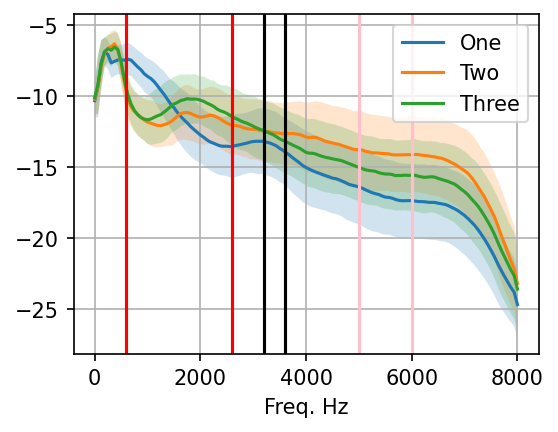

In [423]:
# average spectums for each class
fig, ax = plt.subplots(1, figsize=(4,3), dpi=150)
for k in range(1, 3+1):
    specs = np.log(x_spec_train[y_train==k])
    plt.plot(freq, specs.mean(0), label=['One', 'Two', 'Three'][k-1])
    plt.fill_between(freq, specs.mean(0)-specs.std(0), specs.mean(0)+specs.std(0), alpha=0.2)
    
plt.legend()
plt.xlabel('Freq. Hz')
band = (600, 2600)
[plt.axvline(b, color='r') for b in band]
band2 = (3200, 3600)
[plt.axvline(b, color='black') for b in band2]
band3 = (5000, 6000)
[plt.axvline(b, color='pink') for b in band3]

In [424]:
def extract_features(x, band, band2, band3):
    freq, spec = sg.welch(x, fs, axis=1)
    features = spec[:, (freq>band[0]) & (freq<band[1])]
    another_features = spec[:, (freq>band2[0]) & (freq<band2[1])]
    another = spec[:, (freq>band3[0]) & (freq<band3[1])]
    features = np.append(features, another_features, axis=1)
    return np.append(features, another, axis=1)

In [425]:
f_train = extract_features(x_train, band, band2, band3)
f_test  = extract_features(x_test, band, band2, band3)
f_train.shape

(1687, 53)

In [426]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(f_train, y_train)

DecisionTreeClassifier()

In [427]:
y_train_pred = classifier.predict(f_train)
y_test_pred = classifier.predict(f_test)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.7619893428063943)

In [428]:
f_global = extract_features(x_global, band, band2, band3)

In [429]:
y_global = classifier.predict(f_global)

In [430]:
np.savetxt('y_test.txt', y_global.astype(int), encoding='utf-8', fmt='%i')

<h2><center>Another model</center></h2>

In [431]:
model = LogisticRegression(C=750000, max_iter=1e8)
model.fit(f_train, y_train)

y_train_pred = model.predict(f_train)
y_test_pred = model.predict(f_test)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.7308832246591582, 0.7229129662522202)

<h2><center>Another better model</center></h2>

In [432]:
from sklearn.ensemble import RandomForestClassifier

In [446]:
clf = RandomForestClassifier(max_features=None, criterion="entropy",random_state=4200)

In [447]:
clf.fit(f_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None,
                       random_state=4200)

In [448]:
y_train_pred = clf.predict(f_train)
y_test_pred = clf.predict(f_test)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.8454706927175843)

In [450]:
y_global = clf.predict(f_global)
np.savetxt('y_best.txt', y_global.astype(int), encoding='utf-8', fmt='%i')